In [52]:
import os
import random
import string
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from typing import Tuple, Literal, List
from PIL import Image, ImageDraw, ImageFont, ImageFilter
from wonderwords import RandomWord
from tqdm.auto import tqdm
from torchinfo import summary

In [53]:
def generate_text_captcha(text, captcha_type: str = "easy", min_width: int = 512, height: int=224) -> Tuple[Image.Image, str]:
    """
    Generates a text-based CAPTCHA image.
    
    Args:
        text (str): The text to be included in the CAPTCHA.
        captcha_type (str): The type of CAPTCHA to generate ("easy", "hard", "bonus").
        min_width (int): Minimum width of the CAPTCHA image.
        height (int): Height of the CAPTCHA image.
    
    Returns:
        Tuple[Image.Image, str]: A tuple containing the CAPTCHA image and the text.
    
    Easy CAPTCHA: Renders text in Arial font in the center of a white background. 

    Hard CAPTCHA: Renders text in a random font in the center of a random background, adds the following distortions:
        - Random background color ((r, g, b) where each is differently in [200-255])
        - Random font color ((r, g, b) where each is differently in [0-100])
        - Random font size in [50%-70%] of image height
        - 5% rainbow noise
        - Gaussian blur with radius 0.5 pixels
        
    Bonus CAPTCHA: Renders text in a random font in the center of a random background, and follows the Hard CAPTCHA distortions in addition to:
        - Randomly mirrors the text horizontally with 50% probability.
        - If the text is mirrored, background color is red, else green.
    """
    font_height = 156 if captcha_type == "easy" else (random.randint(int(0.5 * height), int(0.7 * height)))
    font_face = "fonts/arial.ttf" if captcha_type == "easy" else "fonts/" + random.choice(os.listdir("fonts")) 
    font = ImageFont.truetype(font_face, font_height)
    text_length = font.getlength(text)
    width = int(max(min_width, text_length + 80))
    if captcha_type == "easy":
        image = Image.new("RGB", (width, height), (255, 255, 255))
    elif captcha_type == "hard":
        image = Image.new("RGB", (width, height),(random.randint(200, 255), random.randint(200, 255), random.randint(200, 255)))
    elif captcha_type == "bonus":
        if random.random() < 0.5:
            image = Image.new("RGB", (width, height), (255, 0, 0))
            text = text[::-1]  
        else:
            image = Image.new("RGB", (width, height), (0, 255, 0))
    else:
        raise ValueError("Invalid captcha_type!")
    draw = ImageDraw.Draw(image)
    x = (width - text_length) // 2
    y = (height - font_height) // 2
    text_color = 'black' if captcha_type == 'easy' else (random.randint(0, 100), random.randint(0, 100), random.randint(0, 100))
    draw.text((x, y), text=text, font=font, fill=text_color)
    if captcha_type != "easy":
        pixels = np.array(image)
        noise = np.random.randint(0, 255, pixels.shape, dtype='uint8')
        pixels = np.where(np.random.rand(*pixels.shape) < 0.05, noise, pixels)
        image = Image.fromarray(pixels)
        image = image.filter(ImageFilter.GaussianBlur(radius=0.5))
    return image, text
    

In [54]:
def generate_dataset(
    path: str = "data/generated/", 
    num_samples: Tuple[int, int, int] = (1000, 1000, 500), 
    word_type: Literal["english_captcha", "random_captcha", "mixed_captcha"] = "english_captcha",
    mix_ratio: float = 0.5
    ) -> None:
    """
    Generates a dataset of CAPTCHA images and saves them to disk.
    
    Args:
        path (str): Directory to save the generated CAPTCHA images.
        num_samples (Tuple[int, int, int]): Number of samples for each CAPTCHA type (easy, hard, bonus).
        word_type (Literal): Type of words to use in CAPTCHAs ("english_captcha", "random_captcha", "mixed_captcha").
        mix_ratio (float): Ratio of english to random words if word_type is "mixed_captcha".
        
    Returns:
        None
        
    Creates or adds samples to the specified directory with the following subdirectories:
        - easy/
        - hard/
        - bonus/
        
    Word types:
        - english_captcha: Uses a random word from 
    """
    os.makedirs(path, exist_ok=True)
    os.makedirs(os.path.join(path, "easy"), exist_ok=True)
    os.makedirs(os.path.join(path, "hard"), exist_ok=True)
    os.makedirs(os.path.join(path, "bonus"), exist_ok=True)
    english_captcha_samples = (0, 0, 0)
    random_capcha_samples = (0, 0, 0)
    if word_type == "english_captcha":
        english_captcha_samples = num_samples
    elif word_type == "random_captcha":
        random_capcha_samples = num_samples
    elif word_type == "mixed_captcha":
        english_captcha_samples = (int(num_samples[0] * mix_ratio), int(num_samples[1] * mix_ratio), int(num_samples[2] * mix_ratio))
        random_capcha_samples = (num_samples[0] - english_captcha_samples[0],
                                 num_samples[1] - english_captcha_samples[1],
                                 num_samples[2] - english_captcha_samples[2])
    else:
        raise ValueError("Invalid word_type!")
    for i in tqdm(range(english_captcha_samples[0]), desc="english_easy"):
        word = RandomWord().word()
        image, text = generate_text_captcha(word, captcha_type="easy")
        image.save(os.path.join(path, "easy", f"{text}.png"))
    for i in tqdm(range(english_captcha_samples[1]), desc="english_hard"):
        word = RandomWord().word()
        image, text = generate_text_captcha(word, captcha_type="hard")
        image.save(os.path.join(path, "hard", f"{text}.png"))
    for i in tqdm(range(english_captcha_samples[2]), desc="english_bonus"):
        word = RandomWord().word()
        image, text = generate_text_captcha(word, captcha_type="bonus")
        image.save(os.path.join(path, "bonus", f"{text}.png")) 
    def get_random_string(min_len=4, max_len=8):
        chars = string.ascii_uppercase + string.digits
        return ''.join(random.choices(chars, k=random.randint(min_len, max_len)))
    for i in tqdm(range(random_capcha_samples[0]), desc="random_easy"):
        word = get_random_string()
        image, text = generate_text_captcha(word, captcha_type="easy")
        image.save(os.path.join(path, "easy", f"{text}.png"))
    for i in tqdm(range(random_capcha_samples[1]), desc="random_hard"):
        word = get_random_string()
        image, text = generate_text_captcha(word, captcha_type="hard")
        image.save(os.path.join(path, "hard", f"{text}.png"))
    for i in tqdm(range(random_capcha_samples[2]), desc="random_bonus"):
        word = get_random_string()
        image, text = generate_text_captcha(word, captcha_type="bonus")
        image.save(os.path.join(path, "bonus", f"{text}.png"))

In [55]:
def preprocess_image(image_path: str) -> np.ndarray:
    """
    Reads an image and applies binarization and noise removal.
    References: 
        - /references/Pre-Processing in OCR!!!. A basic explanation of the most widely… _ by Susmith Reddy _ TDS Archive _ Medium.pdf
        
    Args:
        image_path (str): Path to the input image. 
        
    Returns:"
        np.ndarray: Preprocessed binary image.
        
    Converts the image to grayscale, applies Otsu's thresholding for binarization.
    Denoising is performed using median blur with a kernel size of 3.
    Morphological opening (erosion -> dilation) is applied to remove small noise particularly near character edges.
    """
    img = cv2.imread(image_path)
    if img is None:
        return None
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    denoised = cv2.medianBlur(binary, 3)
    kernel = np.ones((2,2), np.uint8)
    processed_img = cv2.morphologyEx(denoised, cv2.MORPH_OPEN, kernel)
    return processed_img

In [56]:
def segment_characters(binary_img: np.ndarray, pixel_sum_boundary_threshold: int = 0) -> List[np.ndarray]:
    """
    Segments the binary image using Vertical Histogram Projection.
    References: 
        - /references/Pre-Processing in OCR!!!. A basic explanation of the most widely… _ by Susmith Reddy _ TDS Archive _ Medium.pdf
        - /references/Segmentation in OCR !!. A basic explanation of different levels… _ by Susmith Reddy _ TDS Archive _ Medium.pdf
        - /references/What is an OCR __. A basic theoretical overview of the… _ by Susmith Reddy _ TDS Archive _ Medium.pdf
        
    Args:
        binary_img (np.ndarray): Preprocessed binary image.
        
    Returns:
        List[np.ndarray]: List of segmented character images.
        
    Tries the following linear shear transformations to maximize a sharpness heuristic:
    [[1, shear, 0],
     [0,     1, 0]] 
    where shear values are from the following array:
    array([-0.5 , -0.45, -0.4 , -0.35, -0.3 , -0.25, -0.2 , -0.15, -0.1 , -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35, 0.4 ,  0.45,  0.5 ])
    In angular terms, this corresponds to shear angles from approximately -26.57 degrees to +26.57 degrees in 2.86 degree increments.
    
    Sharpness heuristic:
        The sharpness score is defined as the sum of squared differences between consecutive histogram values.
        The shear transformation that yields the highest sharpness score is selected for final segmentation.
        
    Nearest interpolation is used during the shear transformation to preserve binary values.
    
    After selecting the best shear, vertical histogram projection is performed on the sheared image to identify character boundaries.
    At the moment, a column with zero pixel sum is used as a boundary between characters, however, more sophisticated methods like thresholding can be used in the future. 
    """
    h, w = binary_img.shape
    best_shear = 0
    max_score = -1
    shear_range = np.linspace(-0.5, 0.5, 21) 
    for shear in shear_range:
        M = np.float32([[1, shear, 0], [0, 1, 0]])
        sheared_img = cv2.warpAffine(binary_img, M, (w, h), flags=cv2.INTER_NEAREST)
        hist = np.sum(sheared_img, axis=0)
        score = np.sum((hist[1:] - hist[:-1]) ** 2)
        if score > max_score:
            max_score = score
            best_shear = shear
    M_best = np.float32([[1, best_shear, 0], [0, 1, 0]])
    final_img = cv2.warpAffine(binary_img, M_best, (w, h), flags=cv2.INTER_NEAREST)
    vertical_hist = np.sum(final_img, axis=0) / 255
    segments = []
    in_segment = False
    start_col = 0
    for col in range(w):
        pixel_sum = vertical_hist[col]
        if pixel_sum > 0 and not in_segment:
            in_segment = True
            start_col = col
        elif pixel_sum == pixel_sum_boundary_threshold and in_segment:
            in_segment = False
            char_crop = final_img[:, start_col:col]
            segments.append(char_crop)
    if in_segment:
        char_crop = final_img[:, start_col:w]
        segments.append(char_crop)   
    return segments

In [57]:
def process_and_save_dataset(source_folder: str, output_folder: str) -> None:
    """
    Orchestrator function to process all images and save characters.
    
    Args:
        source_folder (str): Folder containing source CAPTCHA images.
        output_folder (str): Folder to save segmented character images.
    
    Returns:
        None
    """
    mismatch_count = 0
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    files = [f for f in os.listdir(source_folder) if f.endswith('.png')]
    print(f"Processing {len(files)} images...")
    for filename in tqdm(files, desc="Processing images"):
        file_path = os.path.join(source_folder, filename)
        ground_truth_text = os.path.splitext(filename)[0]
        binary_img = preprocess_image(file_path)
        if binary_img is None:
            continue
        char_imgs = segment_characters(binary_img)
        if len(char_imgs) == len(ground_truth_text):
            for i, char_img in enumerate(char_imgs):
                char_label = ground_truth_text[i]
                save_name = f"{ground_truth_text}_{i}_{char_label}.png"
                os.makedirs(os.path.join(output_folder, f"{char_label}"), exist_ok=True)
                save_path = os.path.join(output_folder, f"{char_label}", save_name)
                cv2.imwrite(save_path, char_img)
        else:
            mismatch_count += 1
    print(f"Processing complete. {mismatch_count} mismatches found.")

In [7]:
generate_dataset("data/generated/", (50000, 50000, 25000), "mixed_captcha", 0.5)

random_bonus: 100%|██████████| 12500/12500 [08:11<00:00, 25.44it/s]


In [8]:
process_and_save_dataset('data/generated/hard/', 'data/processed/characters/')
process_and_save_dataset('data/generated/easy/', 'data/processed/characters/')

Processing 32773 images...


Processing images:   0%|          | 0/32773 [00:00<?, ?it/s]

Processing images: 100%|██████████| 32773/32773 [03:40<00:00, 148.74it/s]


Processing complete. 3846 mismatches found.
Processing 32783 images...


Processing images: 100%|██████████| 32783/32783 [03:02<00:00, 179.85it/s]

Processing complete. 2265 mismatches found.


In [58]:
class CharNet(nn.Module):
    """
    VGG-Style CNN model for character recognition - 1.17M.
    
    Total params: 1,174,014
    Trainable params: 1,174,014
    Non-trainable params: 0
    
    The following tensor dimension trace will be there assuming a 32 x 32 image:
    
    INPUT       -                   B  x    1  x  32  x  32
    BLOCK 1     Conv + Pool         B  x   32  x  16  x  16
    BLOCK 2     Conv + Pool         B  x   64  x   8  x   8
    BLOCK 3     Conv + Pool         B  x  128  x   4  x   4
    FLATTEN     Reshape             B  x 2048
    CLASSIIFIER Linear              B  x  512
    OUTPUT      Linear              B  x   62
    
    Block 1:
        - Conv2d: 1 -> 32, 3x3 kernel, padding 1.
        - BatchNorm2d.
        - ReLU.
        - MaxPool2d: 2x2 kernel, stride 2.

    Block 2:
        - Conv2d: 32 -> 64, 3x3 kernel, padding 1.
        - BatchNorm2d.
        - ReLU.
        - MaxPool2d: 2x2 kernel, stride 2.

    Block 3:
        - Conv2d: 64 -> 128, 3x3 kernel, padding 1.
        - BatchNorm2d.
        - ReLU.
        - MaxPool2d: 2x2 kernel, stride 2.

    Classifier:
        - Flatten: Reshape (B, 128, H/8, W/8) to (B, Features).
        - LazyLinear: Features -> 512 .
        - ReLU: Activation.
        - Dropout: Drops 50% of neurons.
        - Linear: 512 -> num_classes.

    Args:
        input_size (int): Expected height/width of square input image (default 32).
        num_classes (int): Number of output classes (default 62).
    
    """
    def __init__(self, input_size: int = 32, num_classes: int = 62):
        super(CharNet, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.classifier(x)
        return x
    
model = CharNet(input_size=32, num_classes=62)
summary(model, input_size=(1, 1, 32, 32), col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
CharNet                                  [1, 1, 32, 32]            [1, 62]                   --
├─Sequential: 1-1                        [1, 1, 32, 32]            [1, 32, 16, 16]           --
│    └─Conv2d: 2-1                       [1, 1, 32, 32]            [1, 32, 32, 32]           320
│    └─BatchNorm2d: 2-2                  [1, 32, 32, 32]           [1, 32, 32, 32]           64
│    └─ReLU: 2-3                         [1, 32, 32, 32]           [1, 32, 32, 32]           --
│    └─MaxPool2d: 2-4                    [1, 32, 32, 32]           [1, 32, 16, 16]           --
├─Sequential: 1-2                        [1, 32, 16, 16]           [1, 64, 8, 8]             --
│    └─Conv2d: 2-5                       [1, 32, 16, 16]           [1, 64, 16, 16]           18,496
│    └─BatchNorm2d: 2-6                  [1, 64, 16, 16]           [1, 64, 16, 16]           128
│    └─ReLU: 2-7             

In [65]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])
data_path = "data/processed/characters"
full_dataset = datasets.ImageFolder(root=data_path, transform=transform)
print(f"Total images found: {len(full_dataset)}")
print(f"Classes found: {len(full_dataset.classes)}")
print(f"Class to Index Mapping: {list(full_dataset.class_to_idx.items())}")
inference_lookup = full_dataset.classes
print(f"Index to Class Mapping: {list(full_dataset.classes)}")

Total images found: 325037
Classes found: 62
Class to Index Mapping: [('0', 0), ('1', 1), ('2', 2), ('3', 3), ('4', 4), ('5', 5), ('6', 6), ('7', 7), ('8', 8), ('9', 9), ('A', 10), ('B', 11), ('C', 12), ('D', 13), ('E', 14), ('F', 15), ('G', 16), ('H', 17), ('I', 18), ('J', 19), ('K', 20), ('L', 21), ('M', 22), ('N', 23), ('O', 24), ('P', 25), ('Q', 26), ('R', 27), ('S', 28), ('T', 29), ('U', 30), ('V', 31), ('W', 32), ('X', 33), ('Y', 34), ('Z', 35), ('a', 36), ('b', 37), ('c', 38), ('d', 39), ('e', 40), ('f', 41), ('g', 42), ('h', 43), ('i', 44), ('j', 45), ('k', 46), ('l', 47), ('m', 48), ('n', 49), ('o', 50), ('p', 51), ('q', 52), ('r', 53), ('s', 54), ('t', 55), ('u', 56), ('v', 57), ('w', 58), ('x', 59), ('y', 60), ('z', 61)]
Index to Class Mapping: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k'

In [9]:
BATCH_SIZE = 64

In [10]:
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=4,
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=4,
    pin_memory=True
)
data_iter = iter(train_loader)
images, labels = next(data_iter)
print("\n--- Batch Verification ---")
print(f"Image Batch Shape: {images.shape}")   # SHOULD BE 64 x 1 x 32 x 32
print(f"Label Batch Shape: {labels.shape}")   # SHOULD BE 64

Training set size: 260029
Validation set size: 65008



--- Batch Verification ---
Image Batch Shape: torch.Size([64, 1, 32, 32])
Label Batch Shape: torch.Size([64])


In [11]:
print("Number of GPUs available:", torch.cuda.device_count())
gpu = torch.device("cuda")
print("Using GPU:", torch.cuda.get_device_name(gpu))
print("GPU Memory:", torch.cuda.get_device_properties(gpu).total_memory)

Number of GPUs available: 1
Using GPU: NVIDIA GeForce RTX 3070 Ti Laptop GPU
GPU Memory: 8231387136


In [18]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
L2_WEIGHT_DECAY = 0.0001

In [13]:
model = model.to(gpu)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=L2_WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode="min",
                                                 factor=0.5,
                                                 patience=3)

In [ ]:
def train_step(model: nn.Module,
               loader: DataLoader,
               criterion: nn.Module,
               optimizer: optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """
    Training step for one epoch.
    
    Args:
        model (nn.Module): The neural network model.
        loader (DataLoader): DataLoader for training data.
        criterion (nn.Module): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer for model parameters.
        device (torch.device): Device to run the computations on.
        
    Returns:
        Tuple[float, float]: Average loss and accuracy for the epoch.
    """
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    for images, labels in tqdm(loader, desc="Training", leave=False):
        images = images.to(device)
        labels = labels.to(device)

        # FORWARD PASS
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # BACKWARD PASS AND OPTIMIZATION
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # STATISTICS
        running_loss += loss.item()
        _, predictions = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predictions == labels).sum().item()
    
    average_loss = running_loss/len(loader)
    accuracy = 100 * correct_predictions / total_samples
    return average_loss, accuracy

In [16]:
def validation_step(model: torch.nn.Module,
             loader: DataLoader,
             criterion: torch.nn.Module,
             device: torch.device) -> Tuple[float, float]:
    """
    Validation step for one epoch.
    
    Args:
        model: The model being validated.
        loader: The validation data loader.
        criterion: The loss function.
        device: The device to run the validation on.
    
    Returns:
        average_loss: The average loss over the validation set.
        accuracy: The accuracy of the model on the validation set.
    """
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation", leave=False):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predictions = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predictions == labels).sum().item()
    
    average_loss = running_loss / len(loader)
    accuracy = 100 * correct_predictions / total_samples
    return average_loss, accuracy

In [19]:
history = {
    'train_loss': [], 'train_accuracy': [],
    'validation_loss': [], 'validation_accuracy': []
}
os.makedirs("models", exist_ok=True)
best_validation_accuracy = 0.0
print("\n ----- TRAINING COMMENCED ----- \n")
for epoch in range(NUM_EPOCHS):
    train_loss, train_accuracy = train_step(model, train_loader, criterion, optimizer, gpu)
    validation_loss, validation_accuracy = validation_step(model, val_loader, criterion, gpu)
    scheduler.step(validation_loss)
    
    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_accuracy)
    history['validation_loss'].append(validation_loss)
    history['validation_accuracy'].append(validation_accuracy)
    
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_accuracy:.2f}% | "
          f"Val Loss: {validation_loss:.4f} | Val Acc: {validation_accuracy:.2f}%")
    
    if validation_accuracy > best_validation_accuracy:
        best_validation_accuracy = validation_accuracy
        torch.save(model.state_dict(), "models/best_char_net.pth")
        print(f"--> New best model saved with accuracy: {validation_accuracy:.2f}%")

print("\n ----- TRAINING COMPLETED ----- \n")


 ----- TRAINING COMMENCED ----- 



Epoch [1/10] Train Loss: 0.0228 | Train Acc: 98.92% | Val Loss: 0.0222 | Val Acc: 99.05%
--> New best model saved with accuracy: 99.05%


Epoch [2/10] Train Loss: 0.0226 | Train Acc: 98.93% | Val Loss: 0.0230 | Val Acc: 99.05%
--> New best model saved with accuracy: 99.05%


Epoch [3/10] Train Loss: 0.0188 | Train Acc: 99.04% | Val Loss: 0.0196 | Val Acc: 99.14%
--> New best model saved with accuracy: 99.14%


Epoch [4/10] Train Loss: 0.0188 | Train Acc: 99.04% | Val Loss: 0.0236 | Val Acc: 98.99%


Epoch [5/10] Train Loss: 0.0189 | Train Acc: 99.05% | Val Loss: 0.0195 | Val Acc: 99.12%


Epoch [6/10] Train Loss: 0.0188 | Train Acc: 99.04% | Val Loss: 0.0212 | Val Acc: 99.10%


Epoch [7/10] Train Loss: 0.0187 | Train Acc: 99.05% | Val Loss: 0.0208 | Val Acc: 99.11%


Epoch [8/10] Train Loss: 0.0189 | Train Acc: 99.05% | Val Loss: 0.0206 | Val Acc: 99.11%


Epoch [9/10] Train Loss: 0.0186 | Train Acc: 99.06% | Val Loss: 0.0202 | Val Acc: 99.12%


Epoch [10/10] Train Loss: 0.0168 | Train Acc: 99.11% | Val Loss: 0.0194 | Val Acc: 99.13%

 ----- TRAINING COMPLETED ----- 



In [20]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['validation_loss'], label='Val Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    ax2.plot(history['train_accuracy'], label='Train Acc')
    ax2.plot(history['validation_accuracy'], label='Val Acc')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    plt.show()

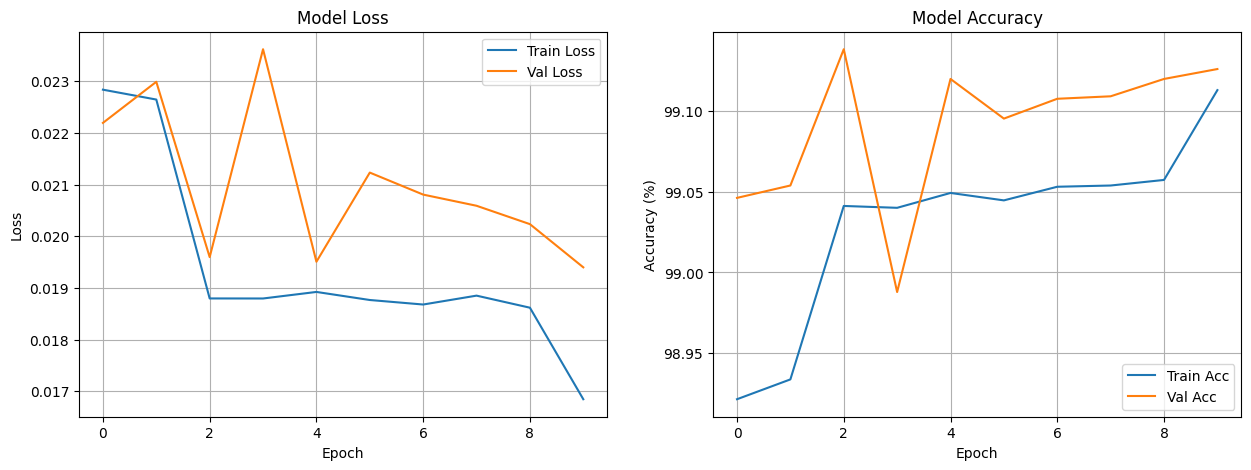

In [21]:
plot_training_history(history)

In [32]:
def generate_task_1_dataset(num_samples: int = 100) -> None:
    """
    Generates dataset for Task 1 with easy and hard CAPTCHAs.
    
    Args:
        num_samples (int): Number of samples to generate.
        
    Returns:
        None
    """
    os.makedirs("task_dataset/task_1/", exist_ok=True)
    os.makedirs("task_dataset/task_1/easy", exist_ok=True)
    os.makedirs("task_dataset/task_1/hard", exist_ok=True)
    for i in tqdm(range(num_samples), desc="Generating Task 1 Dataset"):
        word = RandomWord().word()
        image_easy, _ = generate_text_captcha(word, captcha_type="easy")
        image_hard, _ = generate_text_captcha(word, captcha_type="hard")
        image_easy.save(f"task_dataset/task_1/easy/{word}.png")
        image_hard.save(f"task_dataset/task_1/hard/{word}.png")
        
generate_task_1_dataset(num_samples=100)

Generating Task 1 Dataset: 100%|██████████| 100/100 [00:24<00:00,  4.04it/s]


In [60]:
def load_trained_model(model_path, device):
    model = CharNet(input_size=32, num_classes=62)
    dummy_input = torch.zeros(1, 1, 32, 32)
    model(dummy_input)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

In [61]:
inference_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])
gpu = torch.device("cuda")
cpu = torch.device("cpu")
INFERENCE_DEVICE = cpu
model = load_trained_model("models/best_char_net.pth", INFERENCE_DEVICE)
print("Model loaded successfully.")

Model loaded successfully.


In [27]:
def predict_captcha(model: nn.Module, captcha_image_path: str, inference_device: torch.device) -> str:
    """
    Predicts the text in a CAPTCHA image with the trained model.
    
    Args:
        model (nn.Module): The trained character recognition model.
        captcha_image_path (str): Path to the CAPTCHA image.
    """
    if(model.training == True):
        print("Warning: Model is in training mode. Switching to evaluation mode.")
        model.eval()
    preprocessed_captcha_image = preprocess_image(captcha_image_path)
    captcha_segments = segment_characters(preprocessed_captcha_image)
    predicted_text = ""
    for captcha_segment in captcha_segments:
        transformed_segment = inference_transforms(captcha_segment) 
        inference_output = model(transformed_segment.to(inference_device).unsqueeze(0))
        _, predicted_character_index = torch.max(inference_output.data, 1)
        predicted_text += inference_lookup[predicted_character_index.item()]
    
    return predicted_text

In [28]:
predict_captcha(model, "task_dataset/task_1/hard/anime.png", INFERENCE_DEVICE)

'anime'

In [29]:
task_1_captcha_paths = os.listdir("task_dataset/task_1/easy/")
task_1_labels = [word.split(".png")[0] for word in task_1_captcha_paths]
easy_inferences = []
hard_inferences = []
for captcha_path in tqdm(task_1_captcha_paths, desc="Task 1 Easy Inferences"):
    full_path = os.path.join("task_dataset/task_1/easy/", captcha_path)
    predicted_text = predict_captcha(model, full_path, INFERENCE_DEVICE)
    easy_inferences.append(predicted_text)
for captcha_path in tqdm(task_1_captcha_paths, desc="Task 1 Hard Inferences"):
    full_path = os.path.join("task_dataset/task_1/hard/", captcha_path)
    predicted_text = predict_captcha(model, full_path, INFERENCE_DEVICE)
    hard_inferences.append(predicted_text)

Task 1 Hard Inferences: 100%|██████████| 200/200 [00:35<00:00,  5.69it/s]


In [18]:
total_chars = sum([len(label) for label in task_1_labels])
easy_char_matches = sum([sum(1 for p, l in zip(pred, label) if p == l) for pred, label in zip(easy_inferences, task_1_labels)])
easy_accuracy = (easy_char_matches / total_chars * 100) if total_chars > 0 else 0
hard_char_matches = sum([sum(1 for p, l in zip(pred, label) if p == l) for pred, label in zip(hard_inferences, task_1_labels)])
hard_accuracy = (hard_char_matches / total_chars * 100) if total_chars > 0 else 0

print(f"Task 1 Easy CAPTCHA Character Accuracy: {easy_accuracy:.2f}%")
print(f"Task 1 Hard CAPTCHA Character Accuracy: {hard_accuracy:.2f}%")

Task 1 Easy CAPTCHA Character Accuracy: 90.35%
Task 1 Hard CAPTCHA Character Accuracy: 94.06%


In [30]:
task_2_captcha_paths = os.listdir("task_dataset/task_2/")
task_2_labels = [word.split(".png")[0] for word in task_2_captcha_paths]
task_2_inferences = []
for captcha_path in tqdm(task_2_captcha_paths, desc="Task 2 Inferences"):
    full_path = os.path.join("task_dataset/task_2/", captcha_path)
    predicted_text = predict_captcha(model, full_path, INFERENCE_DEVICE)
    task_2_inferences.append(predicted_text)

Task 2 Inferences: 100%|██████████| 1/1 [00:00<00:00,  5.88it/s]


In [31]:
task_2_total_chars = sum([len(label) for label in task_2_labels])
task_2_char_matches = sum([sum(1 for p, l in zip(pred, label) if p == l) for pred, label in zip(task_2_inferences, task_2_labels)])
task_2_accuracy = (task_2_char_matches / task_2_total_chars * 100) if task_2_total_chars > 0 else 0
print(f"Task 2 CAPTCHA Exact Match Accuracy: {task_2_accuracy:.2f}%")

Task 2 CAPTCHA Exact Match Accuracy: 100.00%


In [62]:
def preprocess_bonus_image(image_path: str) -> Tuple[np.ndarray]:
    """
    Preprocesses bonus CAPTCHA images with special handling for mirrored text.
    
    Args:
        image_path (str): Path to the input image.
    
    Returns:
        Tuple[np.ndarray, bool]: Preprocessed binary image and a boolean indicating if the text is reversed.
        
    Carries out the same preprocessing steps as preprocess_image, but first detects if the background is red or green.
    If the background is red, it indicates that the text is mirrored (reversed).
    """
    img = cv2.imread(image_path)
    if img is None:
        return None
    avg_b, avg_g, avg_r = np.mean(img, axis=(0, 1))
    is_red_bg = False
    is_green_bg = False
    is_reversed = False
    if avg_r > avg_g + 20:
        is_red_bg = True
        is_reversed = True
    elif avg_g > avg_r + 20:
        is_green_bg = True
        is_reversed = False
    lower_bound = np.array([0, 0, 0], dtype=np.uint8)
    upper_bound = np.array([255, 255, 255], dtype=np.uint8)
    if is_red_bg:
        mask = cv2.inRange(img, np.array([0, 0, 150]), np.array([255, 255, 255]))
        img[mask > 0] = [255, 255, 255]
    elif is_green_bg:
        mask = cv2.inRange(img, np.array([0, 150, 0]), np.array([255, 255, 255]))
        img[mask > 0] = [255, 255, 255]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    denoised = cv2.medianBlur(binary, 3)
    kernel = np.ones((2,2), np.uint8)
    processed_img = cv2.morphologyEx(denoised, cv2.MORPH_OPEN, kernel)
    return processed_img, is_reversed

In [63]:
def predict_bonus_captcha(model: nn.Module, captcha_image_path: str, inference_device: torch.device) -> str:
    """
    Predicts the text in a CAPTCHA image with the trained model for the bonus task.
    
    Args:
        model (nn.Module): The trained character recognition model.
        captcha_image_path (str): Path to the CAPTCHA image.
    """
    if(model.training == True):
        print("Warning: Model is in training mode. Switching to evaluation mode.")
        model.eval()
    preprocessed_captcha_image, is_reversed = preprocess_bonus_image(captcha_image_path)
    captcha_segments = segment_characters(preprocessed_captcha_image)
    predicted_text = ""
    for captcha_segment in captcha_segments:
        transformed_segment = inference_transforms(captcha_segment) 
        inference_output = model(transformed_segment.to(inference_device).unsqueeze(0))
        _, predicted_character_index = torch.max(inference_output.data, 1)
        predicted_text += inference_lookup[predicted_character_index.item()]
    
    return predicted_text, is_reversed

In [68]:
bonus_task_captcha_paths = os.listdir("task_dataset/bonus_task/")
bonus_task_labels = [word.split(".png")[0] for word in bonus_task_captcha_paths]
bonus_inferences = []
for captcha_path in tqdm(bonus_task_captcha_paths, desc="Bonus Task Inferences"):
    full_path = os.path.join("task_dataset/bonus_task/", captcha_path)
    predicted_text, is_reversed = predict_bonus_captcha(model, full_path, INFERENCE_DEVICE)
    bonus_inferences.append((predicted_text, is_reversed))

Bonus Task Inferences: 100%|██████████| 56/56 [00:09<00:00,  5.95it/s]


In [69]:
for bonus_inference in bonus_inferences:
    predicted_text, is_reversed = bonus_inference
    if is_reversed:
        predicted_text = predicted_text[::-1]
    print(f"Predicted Text: {predicted_text} | Reversed: {is_reversed}")

Predicted Text: 0CL6T2 | Reversed: False
Predicted Text: 0FJLZ | Reversed: False
Predicted Text: C0BWSKILS | Reversed: False
Predicted Text: BZG3B0 | Reversed: True
Predicted Text: 0E5MZU | Reversed: False
Predicted Text: 0CPPIV | Reversed: False
Predicted Text: 0ABPU | Reversed: False
Predicted Text: 0A52IM2 | Reversed: False
Predicted Text: RY8C0 | Reversed: True
Predicted Text: ZHA0 | Reversed: True
Predicted Text: RL7XA0 | Reversed: True
Predicted Text: BY87G0 | Reversed: True
Predicted Text: 99PTHD0 | Reversed: True
Predicted Text: 0BJZ4FEI | Reversed: False
Predicted Text: 8WKB0 | Reversed: True
Predicted Text: 0F0UMOH | Reversed: False
Predicted Text: 0E0ILM6 | Reversed: False
Predicted Text: W1CO | Reversed: True
Predicted Text: 1F3G0 | Reversed: True
Predicted Text: BNCFSRA0 | Reversed: True
Predicted Text: 0FG4ZHDU | Reversed: False
Predicted Text: 0C8ME | Reversed: False
Predicted Text: 0FI9M | Reversed: False
Predicted Text: 1AD0 | Reversed: True
Predicted Text: 76A0 | Reve